In [1]:
# -*- coding: utf-8 -*-
"""
The script demonstrates a comparison of vehicle times from AVL data to the
scheduled arrival time at one stop for one example trip.
"""

import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
from itertools import compress
import time
%matplotlib inline  
import sys
sys.path.append('/gpfs2/projects/project-bus_capstone_2016/workspace/mu529/bus-Capstone')

# these two modules are homemade
import gtfs
import arrivals
import time
import ttools
os.chdir('/gpfs2/projects/project-bus_capstone_2016/workspace/share')

In [8]:
def interpolate_stops3(merged_row):
    # trip_id = avl_data.index.get_level_values('Trip')[0]
    # stops_ex = list(pd.unique(avl_data.MonitoredCallRef))
    
    # Remove faulty data from head and tail of each trip
    # first = stops_ex[0]
    # last = stops_ex[-1]
    # last_set = avl_data[avl_data.MonitoredCallRef==last][['DistFromCall','PresentableDistance']]
    # first_set = avl_data[avl_data.MonitoredCallRef==first][['DistFromCall','PresentableDistance']]
    # avl_data = avl_data[avl_data.MonitoredCallRef!=last][avl_data.MonitoredCallRef!=first]
    # avl_data.append(avl_data[avl_data.MonitoredCallRef!=last].iloc[0])
    # avl_data.append(avl_data[avl_data.MonitoredCallRef!=first].iloc[-1])
    # distance_stops = list(pd.unique(avl_data.CallDistAlongRoute))
    distance_stops = merged_row.stop_dist_on_trip
    if len(merged_row.timestamp)<2:
        # print merged_row.shape_id + ': ' + 'Not long enough data'
        return [[]]    
    # List of stops in each trip
    # stops_route = pd.DataFrame([stops_ex,distance_stops])
    # stops_route = stops_route.T
    # stops_route.columns=['MonitoredCallRef','CallDistAlongRoute']
    # pattern = '%Y-%m-%dT%H:%M:%S'
    # inter_stops = pd.DataFrame([],columns = ["DistAlongRoute","TimeStamp"])
    list1, list2 = zip(*sorted(zip(merged_row.timestamp,merged_row.veh_dist_along_trip)))
    veh_pings = pd.Series(index=list1,data=list2)
    # trip_data.sort('timestamp',inplace=True)
    last = veh_pings.idxmax()
    first = veh_pings.sort_index(ascending=False).idxmin()
    veh_pings = veh_pings.dropna()
    if len(veh_pings) == 0:
        return [[]]
    inter_stops = veh_pings.loc[first:last]#,['veh_dist_along_trip','timestamp']]
    if len(inter_stops)<2:
        # print merged_row.shape_id + ': ' + 'Not long enough inter'
        return [[]]
    # print merged_row.shape_id + ': ' + str(len(inter_stops))
    # inter_stops['DistAlongRoute'] = avl_data.CallDistAlongRoute - avl_data.DistFromCall
    # inter_stops['TimeStamp'] = avl_data.index.get_level_values('RecordedAtTime')
    # inter_stops['TimeStamp'] = inter_stops['TimeStamp'].apply(lambda x: int(time.mktime(time.strptime(x[:-10], pattern))))
    # inter_stops = inter_stops.reset_index()
    # plt.figure(figsize=(8,4))
    # plt.scatter(inter_stops.timestamp/ttools.datetime.timedelta(seconds=1),inter_stops.veh_dist_along_trip)
    # plt.title('Visualization of single trip.')
    # plt.xlabel('Time (epoch)')
    # plt.ylabel('Distance along route')
    x = inter_stops.values
    y = inter_stops.index.values
    f = interpolate.interp1d(x,y)
    xnew = distance_stops
    masker = (xnew > min(x)) & (xnew < max(x))
    xnew = list(compress(xnew,masker))
    interp_times = pd.to_timedelta(f(xnew),unit='ns')
    # ynew = f(xnew)   # use interpolation function returned by `interp1d`
    # plt.figure(figsize=(10,5))
    # plt.plot(y,x, 'o',color='blue',markersize=5)
    # plt.plot(ynew, xnew, '*',color='red',markersize=15)
    # plt.title('Measured and inferred positions')
    # plt.legend()
    
    return [list(compress(merged_row.next_stop_id,masker)),interp_times]
    # return interp_times

## Now try it on a WHOLE DAY of data...
### Remember to cut stop distances as >0.1
### Also - this just takes the most common shape_id

In [2]:
# get the sample of parsed AVL data.  Beware, large files take more time.
bustime = pd.read_csv('spark_parse/1203.txt',header=None)

# beware!  Bonan is still working on organizing the extract files.  these columns may change.
bustime.columns = ['route','lat','lon','timestamp','vehicle_id','trip_id','trip_date','shape_id',
                   'next_stop_id','dist_from_stop','stop_dist_on_trip','presentable_dist']

bustime.drop_duplicates(['vehicle_id','timestamp'],inplace=True)
bustime['trip_id'] = bustime['trip_id'].str.replace('MTA NYCT_','')
bustime['trip_id'] = bustime['trip_id'].str.replace('MTABC_','')

In [17]:
bustime['route'] = bustime['route'].str.replace('MTA NYCT_','')
bustime['route'] = bustime['route'].str.replace('MTABC_','')
bustime['shape_id'] = bustime['shape_id'].str.replace('MTA_','')
bustime['vehicle_id'] = bustime['vehicle_id'].str.replace('MTA NYCT_','')
bustime['vehicle_id'] = bustime['vehicle_id'].str.replace('MTABC_','')

In [19]:
bustime.set_index(['route','shape_id','vehicle_id'],inplace=True)
bustime.set_index('timestamp',append=True,drop=False,inplace=True)

In [29]:
bustime.sort_index(inplace=True)
bustime['timestamp'] = bustime['timestamp'].apply(ttools.parseActualTime,tdate='2015-12-03')

bustime['stop_dist_on_trip'] = bustime['stop_dist_on_trip'].convert_objects(convert_numeric=True)
bustime['dist_from_stop'] = bustime['dist_from_stop'].convert_objects(convert_numeric=True)
bustime['veh_dist_along_trip'] = bustime['stop_dist_on_trip'] - bustime['dist_from_stop']

print 'Finished loading BusTime data, parsing timestamps, and slicing ONE DAY.'

Finished loading BusTime data, parsing timestamps, and slicing ONE DAY.


In [31]:
bustime.groupby(level=(0,1,2))['veh_dist_along_trip'].max()

route  shape_id  vehicle_id
B1     B1O0216   4877           4472.11
                 4992           4248.22
       B1O0242   4858           2194.92
                 4888           1803.24
                 4989           1997.66
                 5082           2149.55
                 5085           2457.20
                 5088           2428.41
                 5103           2344.11
                 7155           2446.73
                 7159           2393.82
       B1O0243   4855          10881.33
                 4858          10767.31
                 4865          10881.33
                 4867          10866.23
                 4876          10881.33
                 4877          10881.33
                 4878          10881.33
                 4879          10872.29
                 4888          10871.56
                 4889          10649.44
                 4890          10881.33
                 4892          10881.33
                 4893          10881.33
            

In [98]:
def matthew3(seq):
    end_idx_local = 0
    start_idx_local = 0
    start_idx_best = 0
    end_idx_best = 0
    local_max_len = 0
    best_len = 0
    local_runs = []
    for i in xrange(1, len(seq)):
        if seq[i] < seq[i-1]:
            # then it's decreasing
            # first check if was a new record
            local_max_len = end_idx_local - start_idx_local
            if local_max_len >= best_len:
                # print str(i) + ': found or matched a new best!'
                best_len = local_max_len # reset the best length
                start_idx_best = start_idx_local
                end_idx_best = i  # and remember the local indexes as the best 
            else:
                # print str(i) + ': decreased, but not a new record.'
                # forget and move on
                continue
            # if it's longer than 2, remember the locations
            if local_max_len > 2:
                local_runs.append([start_idx_local,end_idx_local])
            # but no matter what, reset the locals
            start_idx_local = i
            end_idx_local = i
            # print str(i) + ': starting over.'
        else:
            # don't reset the start index!
            end_idx_local = i
            local_max_len = end_idx_local - start_idx_local
            # print str(i) + ': good.  max len so far: ' + str(local_max_len)
    if local_max_len > best_len:
        # print 'ended on best'
        best_len = local_max_len
        start_idx_best = start_idx_local
        end_idx_best = i
        if local_max_len > 2:
            local_runs.append([start_idx_local,end_idx_local])
    # run_labels = np.zeros(len(seq),dtype=int)
    run_labels = pd.Series(index=seq.index)
    label = 0
    for run in local_runs:
        label += 1
        run_labels[run[0]:run[1]] = int(label)
    return run_labels

In [99]:
bustime_short = bustime.iloc[:4001]

In [100]:
bustime_short['run_label'] = bustime_short.groupby(level=(0,1,2))['veh_dist_along_trip'].apply(matthew3)

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [103]:
bustime['run_label'] = bustime.groupby(level=(0,1,2))['veh_dist_along_trip'].apply(matthew3)

In [105]:
bustime_new = bustime.set_index('run_label',append=True)

In [106]:
bustime_old = bustime.set_index('trip_id',append=True)

In [108]:
len(bustime_old.groupby(level=(0,1,2,4)))

68139

In [110]:
len(bustime_new.groupby(level=(0,1,2,4)))

41797

In [112]:
len(bustime.groupby(level=(0,1,2)))

26597

# whats this garbage

In [2]:
bustime.set_index(['route','trip_id','trip_date','vehicle_id'],inplace=True,drop=True)
bustime.set_index('timestamp',append=True,drop=False,inplace=True)

# for demonstration, use a subset. Just get data for one line (B41) on one day.
tripDateLookup = "2015-12-03"
# lineLookup = "MTA NYCT_B41"
bustime = bustime.xs((tripDateLookup),level=(2),
                           drop_level=False)
# note that the AVL dataframe must be sorted by timestammp, since iloc[]
# selection is used later in this script to find the earliest time
bustime.sort_index(inplace=True)
bustime['timestamp'] = bustime['timestamp'].apply(ttools.parseActualTime,tdate='2015-12-03')

bustime['stop_dist_on_trip'] = bustime['stop_dist_on_trip'].convert_objects(convert_numeric=True)
bustime['dist_from_stop'] = bustime['dist_from_stop'].convert_objects(convert_numeric=True)
bustime['veh_dist_along_trip'] = bustime['stop_dist_on_trip'] - bustime['dist_from_stop']

print 'Finished loading BusTime data, parsing timestamps, and slicing ONE DAY.'

bustime_distances = bustime.drop(['timestamp'],axis=1,inplace=False)
bustime_distances = bustime_distances.reset_index().drop(['route','trip_id','trip_date','vehicle_id','timestamp',
                                                'lat','lon','dist_from_stop','presentable_dist',
                                                'veh_dist_along_trip'],axis=1,inplace=False)

Finished loading BusTime data, parsing timestamps, and slicing ONE DAY.


In [3]:
stop_distances = bustime_distances.drop_duplicates(['shape_id','next_stop_id','stop_dist_on_trip'])
stop_distances = stop_distances.query('stop_dist_on_trip > 0.1')
stop_distances.shape_id = stop_distances.shape_id.str.replace('MTA_','')
stop_distances.next_stop_id = stop_distances.next_stop_id.str.replace('MTA_','')

stop_distances = stop_distances.sort(['shape_id','stop_dist_on_trip']).reset_index(drop=True)

avl_data2 = bustime
avl_data2.shape_id = avl_data2.shape_id.str.replace('MTA_','')
avl_data2.next_stop_id = avl_data2.next_stop_id.str.replace('MTA_','')

In [4]:
gb = avl_data2.groupby(level=(0,1,2,3))#,4))

In [5]:
reported_timestamps = gb['timestamp'].apply(list)
reported_dists = gb['veh_dist_along_trip'].apply(list)
shape_ids = gb['shape_id'].agg(lambda x:x.value_counts().index[0])

In [6]:
all_dists = stop_distances.groupby('shape_id')['stop_dist_on_trip'].apply(list)
all_stops = stop_distances.groupby('shape_id')['next_stop_id'].apply(list)
all_stop_dists = pd.DataFrame(shape_ids).merge(pd.DataFrame(all_dists),left_on='shape_id',right_index=True).merge(pd.DataFrame(all_stops),left_on='shape_id',right_index=True)
avl_merged = pd.concat([all_stop_dists,reported_timestamps,reported_dists],axis=1)

In [9]:
results = {}
for i, v in avl_merged.iterrows():
    results[i] = interpolate_stops3(v)

In [10]:
lens = []
trip_count = 0
for k, v in results.iteritems():
    l = len(v[0])
    if l > 0:
        trip_count += 1
    lens.append(l)

In [11]:
print sum(lens)
print len(lens)
print trip_count
print 1.0*sum(lens)/trip_count

1546160
66086
48825
31.6673835125


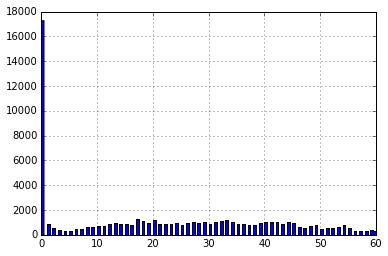

In [13]:
pd.Series(lens).hist(range=(0,60),bins=30)

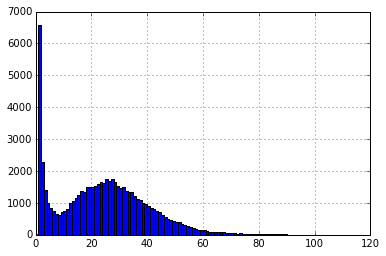

In [14]:
gb.size().hist(range=(0,120),bins=120)

data = pd.read_csv('longjsons_parsed.csv')
data.drop_duplicates(['vehicleID','RecordedAtTime'],inplace=True)
data.set_index(['Line','Trip','TripDate','vehicleID','RecordedAtTime'],inplace=True,drop=True,verify_integrity=True)
# for now, use a truncated data set.  just get data for one line (M5).
tripDateLookup = "2016-05-25"
lineLookup = "MTA NYCT_B41"
avl_long = data.xs((lineLookup,tripDateLookup),level=(0,2),drop_level=False)

trips = pd.unique(avl_long.index.get_level_values('Trip'))
for tp in trips:
    try:
        interpolate_stops(avl_long[avl_long.index.get_level_values('Trip') == tp])
    except ValueError:
        continue
    except IndexError:
        continue

data.index.get_level_values('Trip')

#### Note: sometimes the stations are missing but maybe this can be solved without GTFS after all the trips are aggregated.